<a href="https://colab.research.google.com/github/EvanMansfield/CFP_Prediction_FinalProject/blob/main/CFP_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Drive Integration Section (Mounting Drive)**
**Code Highlights:**

Uses google.colab.drive to access Google Drive files.
Mounts the Google Drive folder at /content/drive.
Allows reading and writing of files directly within your Google Drive.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# **CFB Data Packages, installs & functions**

**Code Highlights:**  
* **Packages Installed**:  
  - `pandas`, `numpy` for data manipulation.  
  - `scikit-learn` for machine learning (Logistic Regression, StandardScaler, LabelEncoder).  
  - `xgboost` for XGBoost classification.  
  - `matplotlib`, `seaborn` for data visualization.  
  - `requests`, `beautifulsoup4`, and `lxml` for web scraping.  
  - `urllib3` for secure HTTP requests.

* **Web Scraping**:  
  - Extracts College Football data from **Sports Reference** using `requests` and `BeautifulSoup`.  
  - Filters relevant columns and saves the output as a **CSV file**.

* **Data Preprocessing**:  
  - Handles missing values using `SimpleImputer`.  
  - Standardizes numeric features using `StandardScaler`.  
  - Encodes categorical columns (like `conf_x`) using `LabelEncoder`.

* **Logistic Regression Model**:  
  - Predicts whether a team makes the **College Football Playoff** based on key performance metrics.  
  - Outputs probabilities, accuracy scores, and a classification report.  
  - Incorporates **AP ranking** as a feature to enhance predictions.

* **XGBoost Model**:  
  - Trains an **XGBoost Classifier** to predict playoff chances.  
  - Provides better handling of large datasets and missing values.  
  - Outputs playoff probabilities and compares performances.

* **Visualization**:  
  - Creates line plots and bar graphs showing playoff probabilities.  
  - Displays team names, AP rankings, and conference groupings.  

**What It Does:**  
**This script scrapes, cleans, and processes College Football data for the years 2016–2023. It trains both a Logistic Regression and an XGBoost model to predict playoff chances for teams in 2024. The predictions are visualiz


In [ ]:
# General Libraries
import pandas as pd
import numpy as np

# Web Scraping
import requests
from bs4 import BeautifulSoup

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost Model
import xgboost as xgb

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System Utilities
import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings()


# **CFB 2024 Teams Scraper**

**Code Highlights:**  
* **Scrapes** the `2024 College Football Ratings` table from `sports-reference.com`.  
* **Parses** the HTML content using **BeautifulSoup** to locate the target table.  
* **Extracts** specific columns, focusing on `School` and `Conference` for streamlined analysis.  
* **Converts** the extracted data into a **pandas DataFrame** for further processing.  
* **Exports** the filtered data to a **CSV file** in Google Drive for persistence.

**What It Does:**  
**This script retrieves the latest 2024 College Football team ratings data from an online source. It specifically extracts team names (School) and their respective conferences (Conf). The processed data is saved as a CSV file, making it readily available for subsequent analysis, modeling, or reporting.**




In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Set the output file path in your Google Drive
output_path = '/content/drive/MyDrive/2024_cfb_teams.csv'

# URL to scrape
url = "https://www.sports-reference.com/cfb/years/2024-ratings.html"

# Send a GET request
response = requests.get(url, verify=False)
if response.status_code == 200:
    soup_content = BeautifulSoup(response.content, "lxml")

    # Find the target table
    target_table = soup_content.find("table", {"id": "ratings"})

    if target_table:
        # Extract headers (manually named for clarity)
        headers = [
            "Rk", "School", "Conf", "AP Rank", "W", "L", "OSRS", "DSRS", "SRS",
            "Scoring Off", "Scoring Def", "Passing Off", "Passing Def",
            "Rushing Off", "Rushing Def", "Total Off", "Total Def"
        ]

        # Extract rows
        rows = []
        for row in target_table.find("tbody").find_all("tr"):
            # Skip header or footer rows if they exist
            if "thead" in row.get("class", []):
                continue

            # Extract data for each column
            cols = row.find_all(["th", "td"])
            row_data = [col.text.strip() for col in cols]
            rows.append(row_data)

        # Convert rows to a DataFrame
        schools_df = pd.DataFrame(rows, columns=headers[:len(rows[0])])

        # Keep only 'School' and 'Conf' columns
        schools_conf_df = schools_df[['School', 'Conf']]

        # Save the filtered DataFrame to Google Drive as a CSV file
        schools_conf_df.to_csv(output_path, index=False)
        print(f"CSV file with 'School' and 'Conf' saved at: {output_path}")

        # Print the filtered DataFrame
        print(schools_conf_df.head())

    else:
        print("Table with ID 'ratings' not found.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")


CSV file with 'School' and 'Conf' saved at: /content/drive/MyDrive/2024_cfb_teams.csv
       School     Conf
0  Ohio State  Big Ten
1  Notre Dame      Ind
2      Oregon  Big Ten
3       Texas      SEC
4     Georgia      SEC


# **Sport Reference Scraper Section (Per Year Ratings)**

**Code Highlights:**  
* **Uses** `requests.get` **to fetch the webpage content.**  
* **Parses** HTML content with `BeautifulSoup` **to locate the table with a specific id.**  
* **Converts** the located table into a Pandas DataFrame **using** `pd.read_html`.  
* **Adds** a `Year` column **for clear data segmentation.**  

**What It Does:**  
**This section retrieves a specific table of sports data for a given year from the Sports Reference website, processes it into a structured format (DataFrame), and adds contextual information like the year for identification.**

> Add blockquote




In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import urllib3
import time

# Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Function to scrape data for a given year
def scrape_yearly_data(year):
    url = f"https://www.sports-reference.com/cfb/years/{year}-ratings.html"
    retries = 3  # Number of retries for failed connections
    for attempt in range(retries):
        try:
            response = requests.get(url, verify=False, timeout=10)
            if response.status_code == 200:
                soup_content = BeautifulSoup(response.content, "lxml")
                target_table = soup_content.find("table", {"id": "ratings"})

                if target_table:
                    # Define headers to map the table data
                    headers = [
                        "Rk", "School", "Conf", "AP Rank", "W", "L", "OSRS", "DSRS", "SRS",
                        "Scoring Off", "Scoring Def", "Passing Off", "Passing Def",
                        "Rushing Off", "Rushing Def", "Total Off", "Total Def"
                    ]

                    # Extract rows
                    rows = []
                    for row in target_table.find("tbody").find_all("tr"):
                        if "thead" in row.get("class", []):
                            continue  # Skip header/footer rows
                        cols = row.find_all(["th", "td"])
                        row_data = [col.text.strip() for col in cols]
                        rows.append(row_data)

                    # Convert rows to a DataFrame
                    df = pd.DataFrame(rows, columns=headers[:len(rows[0])])

                    # Add Year column
                    df["Year"] = year

                    return df
                else:
                    print(f"Table with ID 'ratings' not found for year {year}.")
                    return None
            else:
                print(f"Failed to retrieve the webpage for year {year}. Status code: {response.status_code}")
        except Exception as e:
            print(f"Attempt {attempt + 1} failed for year {year}: {e}")
            time.sleep(5)  # Wait before retrying

    print(f"All attempts failed for year {year}. Skipping...")
    return None

# Scrape data for each year and combine into a single DataFrame
all_years_data = []
for year in range(2014, 2024):
    print(f"Scraping data for year {year}...")
    yearly_data = scrape_yearly_data(year)
    if yearly_data is not None:
        all_years_data.append(yearly_data)

# Combine all years into a single DataFrame
if all_years_data:
    final_df = pd.concat(all_years_data, ignore_index=True)

    # Save to CSV in Google Drive path
    output_path = '/content/drive/MyDrive/cfb_ratings_2014_2023.csv'
    final_df.to_csv(output_path, index=False)

    # Preview the DataFrame
    print("\nFinal DataFrame:")
    print(final_df.head())
    print(f"\nCSV file successfully saved at: {output_path}")
else:
    print("No data was scraped.")


Scraping data for year 2014...
Scraping data for year 2015...
Scraping data for year 2016...
Scraping data for year 2017...
Scraping data for year 2018...
Scraping data for year 2019...
Scraping data for year 2020...
Scraping data for year 2021...
Scraping data for year 2022...
Scraping data for year 2023...

Final DataFrame:
  Rk           School            Conf AP Rank   W  L   OSRS   DSRS    SRS  \
0  1           Oregon  Pac-12 (North)       2  13  2  14.36   7.86  22.22   
1  2       Ohio State  Big Ten (East)       1  14  1  13.44   7.00  20.44   
2  3          Alabama      SEC (West)       4  12  2   9.46  10.88  20.34   
3  4  Texas Christian          Big 12       3  12  1  11.20   7.76  18.96   
4  5          Georgia      SEC (East)       9  10  3  10.88   7.96  18.84   

  Scoring Off Scoring Def Passing Off Passing Def Rushing Off Rushing Def  \
0       61.16        5.13       11.41        5.10        6.57        3.39   
1       62.75        5.78       10.71        4.44      

did they make the playoffs. (predictor) did they make it the next season (absoultely)

# **Schedule Scraper**

**Code Highlights:**
* **Uses** `requests.get` **to fetch the webpage content.**
* **Parses** HTML content with `BeautifulSoup` **to locate the table with a specific id (`schedule`).**
* **Extracts** table headers and rows to structure data into a Pandas DataFrame.
* **Converts** relevant columns (`G`, `W`, and `L`) to integers **using** `pd.to_numeric`.
* **Cleans** the data **by dropping invalid rows** (where `G`, `W`, or `L` are `NaN`).
* **Summarizes** total games, wins, and losses for the Oregon team.

**What It Does:**
**This scraper retrieves the football schedule and performance statistics from the Sports Reference website. It processes the data into a clean, structured format (DataFrame), calculates key totals, and provides a final summary DataFrame with the school's name, total games, wins, and losses.**

**Challenges and Limitations:**
While this scraper is capable of efficiently retrieving data from the Sports Reference website. Orginally wanted to exclude the bowl games and conference games but not a single site saves records with out title or bowl games. It is important to note the following challenges:

**Website Blocking:**

The website may block or limit multiple rapid scraping attempts to prevent excessive requests. This can disrupt the scraper's ability to complete data retrieval in a timely manner.
To mitigate this, requests would need to be spaced out significantly to avoid detection, which can slow down the process.

**Cost of Accurate Data:**

For the project to achieve full accuracy and capture real-time or historical data consistently, premium data access from verified providers might be required. This would involve additional costs.
Alternative Free Solution:

Although obtaining the full dataset in one go is challenging, we can sacrifice time and implement a staggered scraping approach. By running the scraper intermittently over a month's time, we can successfully collect the required data for free. This strategy involves introducing significant delays between requests, allowing the scraper to gradually extract data without triggering website blocks.



In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import urllib3
import time

# Suppress HTTPS warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# List of teams to scrape 'ohio-state', 'notre-dame', 'oregon', 'texas', 'georgia', 'penn-state', 'alabama','southern-methodist','south-carolina', 'miami-fl', 'mississippi', 'indiana', 'louisville', 'clemson', 'louisiana-state', 'brigham-young', 'tennessee', 'virginia-tech', 'arizona-state', 'boise-state', 'texas-am',
teams = [
    'iowa', 'colorado','iowa-state', 'kansas-state', 'southern-california', 'florida', 'minnesota', 'illinois', 'michigan', 'baylor'
    # 'missouri', 'army', 'nebraska', 'nevada-las-vegas', 'navy', 'syracuse', 'georgia-tech', 'tulane',
    # 'oklahoma', 'boston-college', 'kansas', 'rutgers', 'vanderbilt', 'duke', 'texas-christian',
    # 'marshall', 'auburn', 'pittsburgh', 'ohio', 'washington', 'arkansas', 'memphis', 'texas-tech',
    # 'louisiana', 'north-carolina', 'wisconsin', 'ucla', 'james-madison', 'kentucky', 'texas-state',
    # 'california', 'cincinnati', 'bowling-green', 'georgia-southern', 'central-florida', 'utah', 'washington-state',
    # 'west-virginia', 'miami-oh', 'north-carolina-state', 'south-alabama', 'old-dominion',
    # 'northern-illinois', 'virginia', 'toledo', 'connecticut', 'michigan-state', 'maryland',
    # 'jacksonville-state', 'wake-forest', 'colorado-state', 'south-florida', 'northwestern', 'buffalo',
    # 'houston', 'sam-houston', 'western-kentucky', 'east-carolina', 'fresno-state', 'texas-san-antonio',
    # 'mississippi-state', 'stanford', 'san-jose-state', 'coastal-carolina', 'appalachian-state',
    # 'north-texas', 'florida-state', 'liberty', 'oregon-state', 'western-michigan', 'arizona',
    # 'oklahoma-state', 'louisiana-monroe', 'arkansas-state', 'troy', 'hawaii', 'purdue', 'nevada',
    # 'akron', 'rice', 'air-force', 'charlotte', 'utah-state', 'eastern-michigan', 'alabama-birmingham', 'georgia-state',
    # 'louisiana-tech', 'wyoming', 'central-michigan', 'ball-state', 'new-mexico', 'florida-international',
    # 'florida-atlantic', 'temple', 'san-diego-state', 'massachusetts', 'texas-el-paso', 'tulsa',
    # 'new-mexico-state', 'southern-mississippi', 'kennesaw-state', 'middle-tennessee-state', 'kent-state'
]

# Base URL structure with placeholders for the team and year
base_url = "https://www.sports-reference.com/cfb/schools/{team}/{year}-schedule.html"

# Define the range of years to scrape (exclude 2020)
years = [year for year in range(2016, 2024) if year != 2020]

# Initialize an empty list to store all yearly data
all_data = []

# Loop through each team
for team in teams:
    print(f"Starting data scrape for team: {team}")
    for year in years:
        url = base_url.format(team=team, year=year)
        print(f"Scraping data for {team} ({year})...")

        try:
            # Send a GET request
            response = requests.get(url, verify=False)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, "html.parser")

                # Find the table with ID 'schedule'
                table = soup.find("table", {"id": "schedule"})

                if table:
                    # Extract headers
                    headers = [header.text.strip() for header in table.find_all("th")]

                    # Extract all rows of data
                    rows = []
                    for row in table.find("tbody").find_all("tr"):
                        if row.get("class") and "thead" in row.get("class"):
                            continue
                        cols = row.find_all(["th", "td"])
                        row_data = [col.text.strip() for col in cols]
                        rows.append(row_data)

                    # Ensure the 12th row exists and extract it
                    if len(rows) >= 12:
                        twelfth_row = rows[11]  # 12th row (index 11)
                        schedule_df = pd.DataFrame([twelfth_row], columns=headers[:len(twelfth_row)])

                        # Append the result
                        totals = {
                            "School": team,
                            "Year": year,
                            "W": schedule_df["W"].iloc[0],  # Wins from 12th game
                            "L": schedule_df["L"].iloc[0],  # Losses from 12th game
                            "G": 12  # Game number
                        }
                        all_data.append(totals)
                    else:
                        print(f"Less than 12 rows found for {team} ({year}).")
                else:
                    print(f"Table with ID 'schedule' not found for {team} ({year}).")
            elif response.status_code == 429:
                print(f"Rate-limited for {team} ({year}). Skipping to next scrape.")
            else:
                print(f"Failed to retrieve the webpage for {team} ({year}). Status code: {response.status_code}")

        except Exception as e:
            print(f"An error occurred: {e}")

    # Wait 30 minutes before moving to the next team
    print(f"Finished scraping for {team}. Waiting 30 minutes before moving to the next team...")
    time.sleep(30 * 60)

# Combine all the data into a final DataFrame
final_df = pd.DataFrame(all_data)

# Print the final combined DataFrame
print("\nFinal Summary DataFrame:")
print(final_df)

# Optionally save the DataFrame to a CSV file
output_path = '/content/drive/MyDrive/college_teams_12th_game_summary.csv'
final_df.to_csv(output_path, index=False)
print(f"CSV file successfully saved at: {output_path}")

Starting data scrape for team: iowa
Scraping data for iowa (2016)...
Failed to retrieve the webpage for iowa (2016). Status code: 403
Scraping data for iowa (2017)...
Failed to retrieve the webpage for iowa (2017). Status code: 403
Scraping data for iowa (2018)...
Failed to retrieve the webpage for iowa (2018). Status code: 403
Scraping data for iowa (2019)...
Failed to retrieve the webpage for iowa (2019). Status code: 403
Scraping data for iowa (2021)...
Failed to retrieve the webpage for iowa (2021). Status code: 403
Scraping data for iowa (2022)...
Failed to retrieve the webpage for iowa (2022). Status code: 403
Scraping data for iowa (2023)...
Failed to retrieve the webpage for iowa (2023). Status code: 403
Finished scraping for iowa. Waiting 30 minutes before moving to the next team...


KeyboardInterrupt: 

In [ ]:
print(all_data)

In [ ]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
all_data_df = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/part_one_teams_record_scraped_3.csv'
all_data_df.to_csv(output_csv_path, index=False)

# Print the entire DataFrame
print("Final Data (All Rows):")
print(all_data_df)

# Confirm the file was saved
print(f"\nThe teams have been scraped and saved to: {output_csv_path}")


Final Data (All Rows):
         School  Year   W  L   G
0   mississippi  2016   5  7  12
1   mississippi  2017   6  6  12
2   mississippi  2018   5  7  12
3   mississippi  2019   4  8  12
4   mississippi  2021  10  2  12
..          ...   ...  .. ..  ..
69     texas-am  2018   8  4  12
70     texas-am  2019   7  5  12
71     texas-am  2021   8  4  12
72     texas-am  2022   5  7  12
73     texas-am  2023   7  5  12

[74 rows x 5 columns]

The teams have been scraped and saved to: /content/drive/MyDrive/part_one_teams_record_scraped_2.csv


# **Data Processing Section Part 1**


### **College Football Playoff Teams Dictionary**

**Code Highlights:**
* **Uses** `pandas` **to create and manipulate a DataFrame.**
* **Defines** a list of dictionaries containing college football playoff teams (lowercased) and their respective years.
* **Converts** the list into a Pandas DataFrame **using** `pd.DataFrame`.
* **Saves** the DataFrame to a CSV file in Google Drive **using** `to_csv`.
* **Integrates** with Google Drive for file storage.

**What It Does:**
**This script creates a structured list of College Football Playoff (CFP) teams from 2014 to 2023. It processes the data into a Pandas DataFrame and saves it as a CSV file in Google Drive. The final CSV contains two columns: `school` and `year`.**


In [ ]:
import pandas as pd

# Data for College Football Playoff teams from 2014-2023 (lowercased)
cfp_teams = [
    {"school": "alabama", "year": 2014},
    {"school": "oregon", "year": 2014},
    {"school": "florida state", "year": 2014},
    {"school": "ohio state", "year": 2014},
    {"school": "alabama", "year": 2015},
    {"school": "clemson", "year": 2015},
    {"school": "michigan state", "year": 2015},
    {"school": "oklahoma", "year": 2015},
    {"school": "alabama", "year": 2016},
    {"school": "clemson", "year": 2016},
    {"school": "ohio state", "year": 2016},
    {"school": "washington", "year": 2016},
    {"school": "alabama", "year": 2017},
    {"school": "clemson", "year": 2017},
    {"school": "georgia", "year": 2017},
    {"school": "oklahoma", "year": 2017},
    {"school": "alabama", "year": 2018},
    {"school": "clemson", "year": 2018},
    {"school": "notre dame", "year": 2018},
    {"school": "oklahoma", "year": 2018},
    {"school": "alabama", "year": 2019},
    {"school": "clemson", "year": 2019},
    {"school": "lsu", "year": 2019},
    {"school": "oklahoma", "year": 2019},
    {"school": "alabama", "year": 2020},
    {"school": "clemson", "year": 2020},
    {"school": "notre dame", "year": 2020},
    {"school": "ohio state", "year": 2020},
    {"school": "alabama", "year": 2021},
    {"school": "cincinnati", "year": 2021},
    {"school": "georgia", "year": 2021},
    {"school": "michigan", "year": 2021},
    {"school": "georgia", "year": 2022},
    {"school": "michigan", "year": 2022},
    {"school": "ohio state", "year": 2022},
    {"school": "tcu", "year": 2022},
    {"school": "georgia", "year": 2023},
    {"school": "michigan", "year": 2023},
    {"school": "washington", "year": 2023},
    {"school": "alabama", "year": 2023}
]

# Convert to DataFrame
cfp_df = pd.DataFrame(cfp_teams)

# Set the output path in Google Drive
output_path = '/content/drive/MyDrive/cfp_teams_2014_2023.csv'

# Save DataFrame to CSV
cfp_df.to_csv(output_path, index=False)
print(f"CSV file successfully saved at: {output_path}")

# **CFB Stats Scraper Section**

**Code Highlights:**  
* **Disables** SSL warnings **using** `urllib3.disable_warnings`.  
* **Fetches** webpage content for College Football stats by year **using** `requests.get`.  
* **Parses** the HTML content **and extracts relevant tables dynamically.**  

**What It Does:**  
**This section fetches yearly College Football stats from a specified website and processes the data into a Pandas DataFrame for further analysis.**



In [ ]:
# Import required libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup
import urllib3

# Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Initialize an empty list to store DataFrames for each year
all_penalty_data = []

# Loop through the years 2014 to 2023
for year in range(2016, 2024):
    # URL for each year
    url = f"https://cfbstats.com/{year}/leader/national/team/offense/split01/category14/sort01.html"
    print(f"Fetching data for year {year}...")

    try:
        # Send a GET request to the URL
        response = requests.get(url, verify=False, timeout=10)  # Timeout for safety

        if response.status_code == 200:
            # Parse the HTML content
            soup_content = BeautifulSoup(response.text, "lxml")

            # Locate the table element
            target_table = soup_content.find("table", {"class": "leaders"})

            if target_table:
                # Convert the table to a DataFrame
                penalty_df = pd.read_html(str(target_table), header=0)[0]

                # Add a 'Year' column
                penalty_df['Year'] = year

                # Append the DataFrame to the list
                all_penalty_data.append(penalty_df)
                print(f"Data for year {year} successfully retrieved.")
            else:
                print(f"Table with class 'leaders' not found for year {year}.")
        else:
            print(f"Failed to retrieve data for year {year}. Status code: {response.status_code}")

    except Exception as e:
        print(f"Error fetching data for year {year}: {e}")

# Combine all yearly DataFrames into a single DataFrame
if all_penalty_data:
    combined_penalty_df = pd.concat(all_penalty_data, ignore_index=True)

    # Preview the combined DataFrame
    print("\nCombined DataFrame:")
    print(combined_penalty_df.head())

    # Define the output path in Google Drive
    output_path = "/content/drive/My Drive/penalty_data_2014_2023.csv"

    # Save the combined DataFrame as a CSV file
    combined_penalty_df.to_csv(output_path, index=False)
    print(f"\nCSV file successfully saved at: {output_path}")
else:
    print("No data was collected.")



Updated DataFrame with 'name' renamed to 'school':
   unnamed: 0        school   g  pen.  yards  pen./g  yards/g  year
0           1          Navy  14    39    341     2.8     24.4  2016
1           2   Connecticut  12    43    339     3.6     28.3  2016
2           3  Northwestern  13    47    389     3.6     29.9  2016
3           4     Wisconsin  14    48    455     3.4     32.5  2016
4           5    Ball State  12    48    426     4.0     35.5  2016


# **Data Processing Part 2 and Cleaning Steps**

**Code Highlights:**  
* **Loads** multiple CSV files **containing key datasets** like ratings, penalties, team data, and playoff results.  
* **Standardizes** all column headers to **lowercase** for consistency across data sources.  
* **Cleans** column values by **stripping whitespace** and converting data to lowercase for alignment.  
* **Merges** datasets using **OUTER JOIN** to **retain all available information** across different files.  
* **Removes unnecessary columns** like `unnamed: 0` to clean up the final DataFrame.

**What It Does:**  
**This section combines all the individual datasets into a unified DataFrame. The process involves cleaning and aligning column names, standardizing school and year formats, and merging data on shared keys (`school`, `year`). The result is a consolidated dataset ready for analysis and machine learning models.**


In [ ]:
# Path to the saved CSV file in Google Drive
csv_path = "/content/drive/MyDrive/cfb_ratings_2014_2023.csv"

# Load the CSV file into a DataFrame
cfb_ratings_df = pd.read_csv(csv_path)

# Convert all column headers to lowercase
cfb_ratings_df.columns = cfb_ratings_df.columns.str.lower()

# Preview the updated DataFrame
print("DataFrame loaded with lowercase headers:")
print(cfb_ratings_df)


DataFrame loaded with lowercase headers:
       rk                 school            conf  ap rank   w   l   osrs  \
0       1                 Oregon  Pac-12 (North)      2.0  13   2  14.36   
1       2             Ohio State  Big Ten (East)      1.0  14   1  13.44   
2       3                Alabama      SEC (West)      4.0  12   2   9.46   
3       4        Texas Christian          Big 12      3.0  12   1  11.20   
4       5                Georgia      SEC (East)      9.0  10   3  10.88   
...   ...                    ...             ...      ...  ..  ..    ...   
1293  129                 Temple        American      NaN   3   9  -7.69   
1294  130  Florida International            CUSA      NaN   4   8  -8.31   
1295  131                 Nevada             MWC      NaN   2  10 -12.92   
1296  132                  Akron      MAC (East)      NaN   2  10 -11.93   
1297  133             Kent State      MAC (East)      NaN   1  11 -12.52   

       dsrs    srs  scoring off  scoring def  

In [ ]:
# Path to the saved CSV file in Google Drive
csv_path = "/content/drive/My Drive/penalty_data_2014_2023.csv"

# Load the CSV file into a DataFrame
combined_penalty_df = pd.read_csv(csv_path)

# Standardize column names to lowercase for comparison
combined_penalty_df.columns = combined_penalty_df.columns.str.lower()

# Rename the 'name' column to 'school' if it exists
if 'name' in combined_penalty_df.columns:
    combined_penalty_df.rename(columns={'name': 'school'}, inplace=True)

# Preview the updated DataFrame
print("\nUpdated DataFrame with 'name' renamed to 'school':")
print(combined_penalty_df.head())



Updated DataFrame with 'name' renamed to 'school':
   unnamed: 0        school   g  pen.  yards  pen./g  yards/g  year
0           1          Navy  14    39    341     2.8     24.4  2016
1           2   Connecticut  12    43    339     3.6     28.3  2016
2           3  Northwestern  13    47    389     3.6     29.9  2016
3           4     Wisconsin  14    48    455     3.4     32.5  2016
4           5    Ball State  12    48    426     4.0     35.5  2016


In [ ]:
# Path to the saved CSV file in Google Drive
csv_path_1 = "/content/drive/MyDrive/2024_cfb_teams.csv"

# Load the CSV file into a DataFrame
cfb_teams_df = pd.read_csv(csv_path_1)

# Convert all column headers to lowercase
cfb_teams_df.columns = cfb_teams_df.columns.str.lower()

# Preview the updated DataFrame
print("DataFrame with lowercase headers:")
print(cfb_teams_df.head())

DataFrame with lowercase headers:
       school     conf
0  Ohio State  Big Ten
1  Notre Dame      Ind
2      Oregon  Big Ten
3       Texas      SEC
4     Georgia      SEC


In [ ]:
# Path to the saved CSV file in Google Drive
csv_path_3 = "/content/drive/MyDrive/cfp_teams_2014_2023.csv"

# Load the CSV file into a DataFrame
cfp_df = pd.read_csv(csv_path_3)

# Convert all column headers to lowercase
cfp_df.columns = cfp_df.columns.str.lower()

# Add a new column labeled 'made playoff' with all values as 1
cfp_df['made playoff'] = 1

# Define the output path in Google Drive
output_path_1 = "/content/drive/MyDrive/cfp_teams_with_playoff_2014_2023.csv"

# Save the updated DataFrame to a new CSV file
cfp_df.to_csv(output_path_1, index=False)

# Preview the updated DataFrame
print("Updated DataFrame with 'made playoff' column:")
print(cfp_df.head())

print(f"\nCSV file successfully saved at: {output_path_1}")


Updated DataFrame with 'made playoff' column:
          school  year  made playoff
0        alabama  2014             1
1         oregon  2014             1
2  florida state  2014             1
3     ohio state  2014             1
4        alabama  2015             1

CSV file successfully saved at: /content/drive/MyDrive/cfp_teams_with_playoff_2014_2023.csv


In [ ]:
# Paths to all CSV files
csv_path_1 = "/content/drive/MyDrive/cfb_ratings_2014_2023.csv"
csv_path_2 = "/content/drive/My Drive/penalty_data_2014_2023.csv"
csv_path_3 = "/content/drive/MyDrive/2024_cfb_teams.csv"
csv_path_4 = "/content/drive/MyDrive/cfp_teams_with_playoff_2014_2023.csv"

# Load all DataFrames
cfb_ratings_df = pd.read_csv(csv_path_1)
penalty_df = pd.read_csv(csv_path_2)
cfb_teams_df = pd.read_csv(csv_path_3)
cfp_playoff_df = pd.read_csv(csv_path_4)

# Standardize column names to lowercase
for df in [cfb_ratings_df, penalty_df, cfb_teams_df, cfp_playoff_df]:
    df.columns = df.columns.str.lower()

# Rename 'name' to 'school' if present
if 'name' in penalty_df.columns:
    penalty_df.rename(columns={'name': 'school'}, inplace=True)

# Strip whitespace, convert to lowercase, and standardize 'school' and 'year'
def clean_data(df, cols):
    for col in cols:
        df[col] = df[col].astype(str).str.strip().str.lower()
    return df

cfb_ratings_df = clean_data(cfb_ratings_df, ['school', 'year'])
penalty_df = clean_data(penalty_df, ['school', 'year'])
cfb_teams_df = clean_data(cfb_teams_df, ['school'])
cfp_playoff_df = clean_data(cfp_playoff_df, ['school', 'year'])

# Drop unnecessary columns (e.g., 'unnamed: 0')
penalty_df = penalty_df.loc[:, ~penalty_df.columns.str.contains('unnamed')]

# Merge DataFrames with OUTER JOIN to retain all data
merged_df = cfb_ratings_df.merge(penalty_df, on=['school', 'year'], how='outer') \
                          .merge(cfp_playoff_df, on=['school', 'year'], how='outer') \
                          .merge(cfb_teams_df, on=['school'], how='outer')

# Fill missing 'made playoff' values with 0
merged_df['made playoff'] = merged_df['made playoff'].fillna(0).astype(int)

# Fill missing 'ap rank' values with 0
if 'ap rank' in merged_df.columns:
    merged_df['ap rank'] = merged_df['ap rank'].fillna(0).astype(int)

# Filter out rows with years 2014 and 2015
merged_df = merged_df[~merged_df['year'].astype(str).isin(['2014', '2015'])]

# Preview the cleaned and filtered DataFrame
print("Filtered Merged DataFrame (without 2014 and 2015, NaN in 'ap rank' as 0):")
print(merged_df.head())

# Save the final DataFrame to Google Drive
output_path = "/content/drive/MyDrive/filtered_merged_cfb_data_2016_2023.csv"
merged_df.to_csv(output_path, index=False)

print(f"\nFiltered and cleaned DataFrame successfully saved at: {output_path}")


Filtered Merged DataFrame (without 2014 and 2015, NaN in 'ap rank' as 0):
     rk     school          conf_x  ap rank     w    l  osrs  dsrs    srs  \
2  49.0  air force  MWC (Mountain)        0  10.0  3.0  4.96 -0.87   4.09   
3  90.0  air force  MWC (Mountain)        0   5.0  7.0  2.55 -7.32  -4.77   
4  84.0  air force  MWC (Mountain)        0   5.0  7.0  0.47 -2.19  -1.72   
5  25.0  air force  MWC (Mountain)       22  11.0  2.0  3.58  6.89  10.47   
6  54.0  air force  MWC (Mountain)        0   3.0  3.0 -7.08  7.93   0.85   

   scoring off  ...  total off  total def  year     g  pen.  yards  pen./g  \
2        45.85  ...       7.00       4.63  2016  13.0  67.0  681.0     5.2   
3        45.12  ...       6.54       5.80  2017  12.0  48.0  465.0     4.0   
4        43.70  ...       6.44       5.20  2018  12.0  54.0  521.0     4.5   
5        45.22  ...       7.30       4.05  2019  13.0  42.0  368.0     3.2   
6        32.71  ...       6.74       5.04  2020   6.0  27.0  245.0     4.

---
# **Key Differences Between both models**:  
| **Logistic Regression**                      | **XGBoost**                               |  
|---------------------------------------------|-----------------------------------------|  
| Simple, interpretable linear model          | Advanced gradient-boosting ensemble      |  
| Evaluates performance via coefficients      | Calculates feature importance scores     |  
| Requires standardized data                  | Handles raw input data effectively       |  
| Predicts playoff probabilities linearly     | Predicts using non-linear relationships  |  

Both models provide accurate playoff probabilities, but **XGBoost** excels with complex relationships and feature importance insights, while **Logistic Regression** offers a simpler, more interpretable output.  


# **CFB Playoff Prediction Model**

## **Logistic Regression Model Non-Penalty**

**Code Highlights:**  
* **Uses** `LogisticRegression` **to predict college football playoff appearances** based on key performance metrics.  
* **Scales** input features **using** `StandardScaler` **to standardize values for better performance.**  
* **Splits** data into **training** (2016-2022) and **testing** (2023) datasets for evaluation.  
* **Evaluates** model accuracy using metrics like **Accuracy Score, Classification Report, and Confusion Matrix**.  
* **Calculates** playoff probabilities for 2024 teams **based on their performance metrics**.  
* **Includes AP Rankings** in predictions to understand the impact of rankings on playoff chances.

**What It Does:**  
The **Logistic Regression model** predicts **College Football Playoff (CFB) appearances** based on historical team performance data, including metrics such as wins, losses, offensive and defensive stats, and AP rankings. It evaluates the model's accuracy on the 2023 data and outputs playoff probabilities for teams in 2024. The results provide insight into which teams have the highest chances of making the playoffs.


In [ ]:
# Import libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Load the data
file_path = '/content/drive/MyDrive/filtered_merged_cfb_data_2016_2023.csv'
df = pd.read_csv(file_path)

# Preprocessing
df = df.dropna(subset=['made playoff', 'year', 'conf_x', 'ap rank'])

# Add 'ranked_2023' column: teams with AP Rank > 0 in 2023
df['ranked_2023'] = df.apply(lambda row: 1 if row['year'] == 2023 and row['ap rank'] > 0 else 0, axis=1)

# Label encode 'conf_x'
label_encoder = LabelEncoder()
df['conf_x'] = label_encoder.fit_transform(df['conf_x'])

# Define Features and Target
features = ['w', 'l', 'osrs', 'dsrs', 'srs', 'scoring off', 'scoring def',
            'passing off', 'passing def', 'rushing off', 'rushing def', 'conf_x']
target = 'made playoff'

# Split Data
train_data = df[df['year'] <= 2022]
test_data = df[df['year'] == 2023]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Handle NaN values with SimpleImputer (fill NaN with mean)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Model Evaluation on 2023 Test Data:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Add probabilities, 'ranked_2023', AP ranking, and scoring columns to the final frame
test_data['playoff_probability'] = y_proba
test_data['ranked_2023'] = test_data['ap rank'].apply(lambda x: 1 if x > 0 else 0)

# Final frame with AP ranking and scoring columns
final_frame = test_data[['school', 'conf_x', 'year', 'playoff_probability',
                         'ap rank', 'scoring off', 'scoring def']]

# Save predictions with AP Ranking and scoring columns
output_path = '/content/drive/MyDrive/logistic_playoff_predictions_with_ap_and_scoring_2024.csv'
final_frame.to_csv(output_path, index=False)

# Display and confirm
print("\nPredictions for Playoff Chances in 2024 (with AP Rank and Scoring Columns):")
print(final_frame.sort_values(by='playoff_probability', ascending=False).head(10))
print(f"\nPredictions saved to: {output_path}")



Logistic Regression Model Evaluation on 2023 Test Data:
Accuracy: 0.9774436090225563

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       129
           1       0.67      0.50      0.57         4

    accuracy                           0.98       133
   macro avg       0.83      0.75      0.78       133
weighted avg       0.98      0.98      0.98       133


Predictions for Playoff Chances in 2024 (with AP Rank and Scoring Columns):
             school  conf_x    year  playoff_probability  ap rank  \
522        michigan       7  2023.0             0.954854        1   
730          oregon      19  2023.0             0.628642        6   
278         georgia      22  2023.0             0.610771        4   
892           texas       6  2023.0             0.479433        3   
1067     washington      19  2023.0             0.426672        2   
690      ohio state       7  2023.0             0.419237       10   
26

# **1. Line Plot: Playoff Probability vs AP Rank**

**Code Highlights:**
* **Filters** out non-ranked teams by removing AP Rank <= 0 or missing values.  
* **Sorts** data by AP Rank in ascending order for a cleaner visualization.  
* **Plots** AP Rank (X-axis) against Playoff Probability (Y-axis).  
* **Annotates** each point with the corresponding team name for better context.

**What It Does:**  
This line plot visualizes the relationship between **AP Rank** and **playoff probability** for AP-ranked teams. Higher-ranked teams (lower AP Rank) are shown along the left of the graph, with **playoff probabilities** plotted on the Y-axis. Team names are labeled for clarity.  


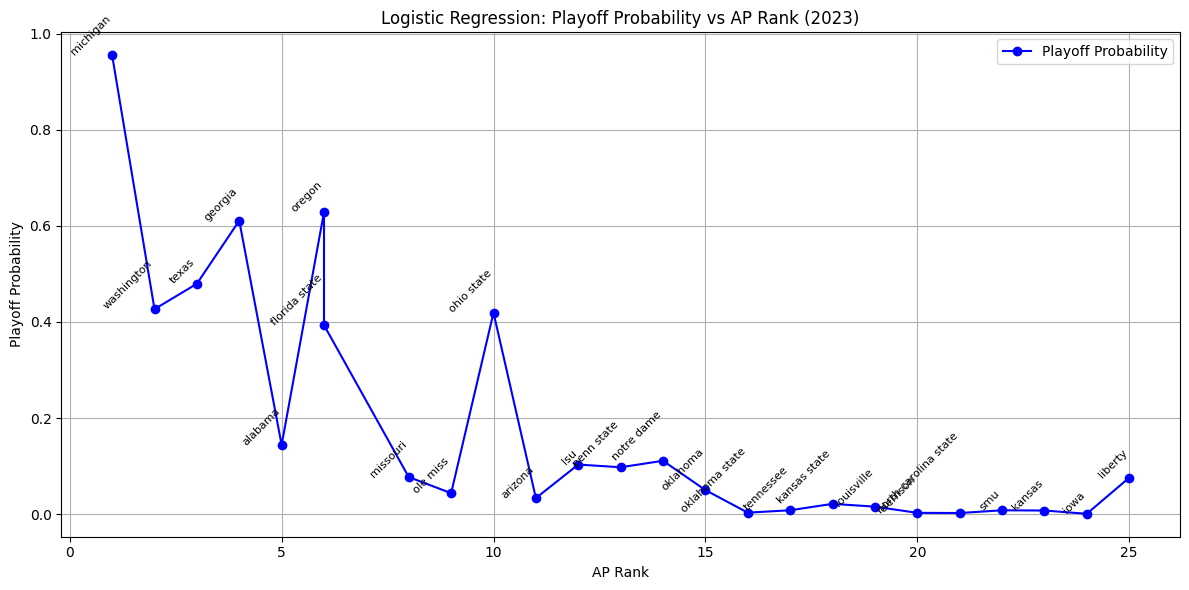

In [ ]:
import matplotlib.pyplot as plt

# Exclude non-ranked teams (AP Rank <= 0 or NaN)
plot_data = final_frame.dropna(subset=['ap rank'])  # Remove NaNs
plot_data = plot_data[plot_data['ap rank'] > 0]    # Keep AP Rank > 0

# Sort data by AP Rank for a cleaner line plot
plot_data = plot_data.sort_values(by='ap rank', ascending=True)

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(plot_data['ap rank'], plot_data['playoff_probability'], marker='o', linestyle='-', color='b', label='Playoff Probability')

# Annotate team names on the plot
for i, row in plot_data.iterrows():
    plt.text(row['ap rank'], row['playoff_probability'], row['school'], fontsize=8, rotation=45, ha='right')

# Add titles and labels
plt.title("Logistic Regression: Playoff Probability vs AP Rank (2023)")
plt.xlabel("AP Rank")
plt.ylabel("Playoff Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()



# **2. Bar Plot: Conference Rankings by Playoff Probability (Logistic Regression Predictions)**

**Code Highlights:**  
* **Groups** the playoff probabilities by conference (`conf_x`) using the Logistic Regression model predictions.  
* **Calculates** the **average playoff probability** for each conference.  
* **Sorts** conferences in descending order based on their average probability.  
* **Visualizes** the rankings as a **bar chart** for easy comparison.  

**What It Does:**  
1. **Aggregates Data:**  
   - Computes the average playoff probability for each conference.  

2. **Ranks Conferences:**  
   - Sorts the conferences from highest to lowest average playoff probability.  

3. **Visualization:**  
   - **X-axis:** Displays the conference names.  
   - **Y-axis:** Shows the average playoff probability.  
   - **Bars:** Represent the relative playoff probability for each conference.  

**Results Interpretation:**  
The bar chart shows the dominance of conferences like **Big Ten (East)** and **SEC (East)**, which have the highest average playoff probabilities. Conferences with lower probabilities (e.g., Sun Belt, MAC, MWC) reflect a reduced likelihood of their teams reaching the playoffs.  
This visualization highlights the competitive imbalance among conferences, providing insights into playoff chances based on team performances.


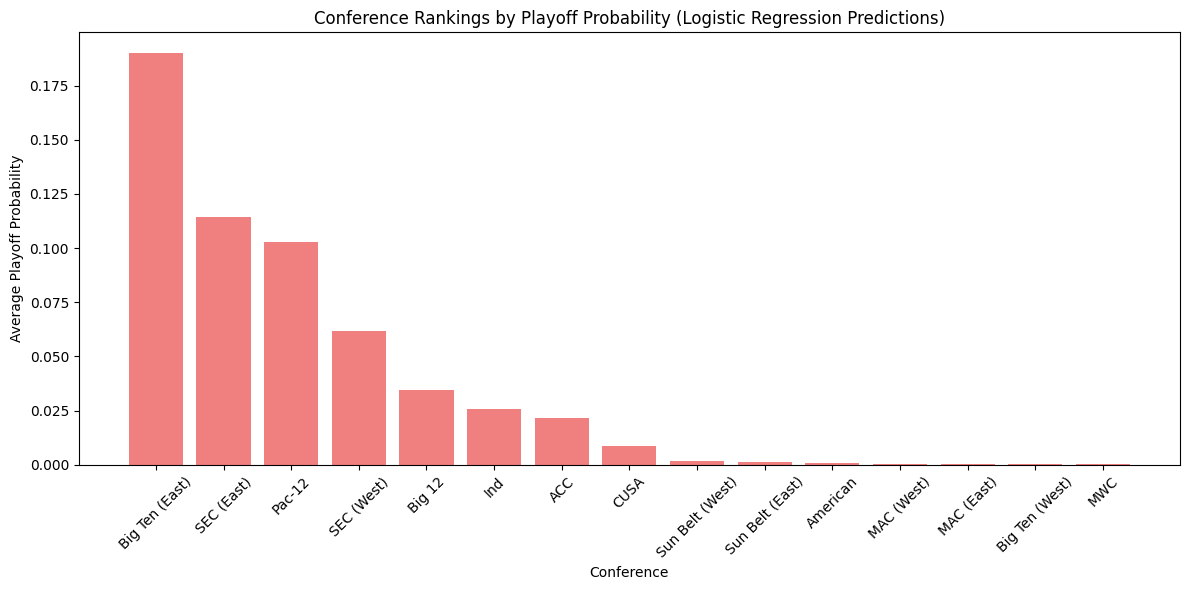

Conference Rankings by Playoff Probability:
             conf_x  playoff_probability
3    Big Ten (East)             0.190076
11       SEC (East)             0.114335
10           Pac-12             0.102680
12       SEC (West)             0.061720
2            Big 12             0.034515
6               Ind             0.025543
0               ACC             0.021411
5              CUSA             0.008905
14  Sun Belt (West)             0.001821
13  Sun Belt (East)             0.001477
1          American             0.000786
8        MAC (West)             0.000334
7        MAC (East)             0.000257
4    Big Ten (West)             0.000149
9               MWC             0.000143


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions CSV file
predictions_path = '/content/drive/MyDrive/logistic_playoff_predictions_2024.csv'
predictions_df = pd.read_csv(predictions_path)

# Step 8: Conference Playoff Probability Analysis
# Group predictions by 'conf_x' and calculate the average playoff probability
conference_rankings = predictions_df.groupby('conf_x')['playoff_probability'].mean().reset_index()

# Sort the conferences by average playoff probability
conference_rankings = conference_rankings.sort_values(by='playoff_probability', ascending=False)

# Step 9: Visualize Conference Rankings
plt.figure(figsize=(12, 6))
plt.bar(conference_rankings['conf_x'], conference_rankings['playoff_probability'], color='lightcoral')

# Add labels and title
plt.xlabel('Conference')
plt.ylabel('Average Playoff Probability')
plt.title('Conference Rankings by Playoff Probability (Logistic Regression Predictions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Print the conference rankings
print("Conference Rankings by Playoff Probability:")
print(conference_rankings)


### **3. Bar Plot: Performance of AP-Ranked Teams for Playoff Predictions (2024)**

**Code Highlights:**  
* **Filters** teams ranked in the AP poll (`ap rank > 0`).  
* **Sorts** teams by their predicted playoff probability (highest to lowest).  
* **Uses Seaborn** to create a horizontal bar plot, showcasing playoff probabilities for AP-ranked teams.  
* **Annotates** each bar with the corresponding **AP Rank** for clarity.  

**What It Does:**  
1. **Filters AP-Ranked Teams:**  
   - Only teams with an `AP Rank > 0` are included in the analysis.  

2. **Sorts Teams:**  
   - Teams are sorted in descending order based on their playoff probability.  

3. **Visualization:**  
   - **X-axis:** Represents the playoff probability for each team.  
   - **Y-axis:** Lists the schools (teams).  
   - **Bar Annotations:** Displays the AP Rank directly on the bars for clear identification.  

**Results Interpretation:**  
This bar plot highlights how teams ranked in the AP poll perform in terms of playoff probability. Teams like **Michigan** and **Oregon** lead the predictions with the highest playoff probabilities, while lower-ranked teams have smaller chances.  
The visualization helps identify top-performing teams relative to their AP rankings and provides insights into the playoff outlook for the 2024 season.  


<ipython-input-41-df4b4fb75960>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


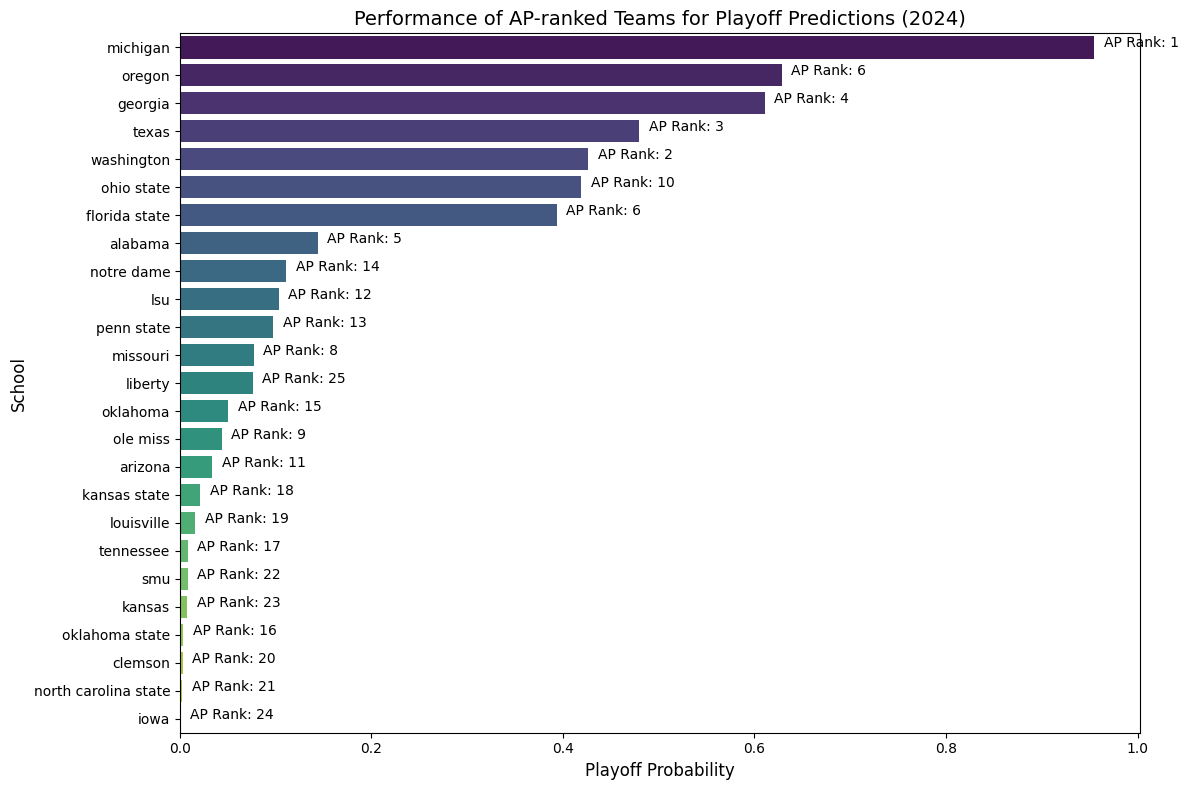

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data to include only AP-ranked teams (AP Rank > 0)
ap_ranked_teams = final_frame[final_frame['ap rank'] > 0].copy()

# Sort the data by playoff probability
ap_ranked_teams = ap_ranked_teams.sort_values(by='playoff_probability', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='playoff_probability',
    y='school',
    data=ap_ranked_teams,
    palette='viridis'
)

# Add labels and titles
plt.title("Performance of AP-ranked Teams for Playoff Predictions (2024)", fontsize=14)
plt.xlabel("Playoff Probability", fontsize=12)
plt.ylabel("School", fontsize=12)

# Display the AP Rank alongside the bars
for index, value in enumerate(ap_ranked_teams['playoff_probability']):
    plt.text(value + 0.01, index, f"AP Rank: {ap_ranked_teams['ap rank'].iloc[index]}", fontsize=10, color='black')

# Show the graph
plt.tight_layout()
plt.show()


### **4. Top 25 Scoring Offense Teams vs Playoff Probability (2024 Predictions)**

**Code Highlights:**  
* **Ranks** and displays the top 25 teams based on **scoring offense** (`scoring off`) values.  
* **Visualizes** their playoff probability predictions using **bar plots**.  
* **Annotates** each bar with the corresponding **scoring offense** values for clarity.  
* **Highlights** the teams predicted to have a higher playoff probability based on scoring performance.

---

**What It Does:**  
This bar plot highlights the **top 25 teams** with the **highest scoring offense** (points per game scored) and their corresponding **playoff probabilities** predicted for the 2024 season.  
- **X-axis**: Team names.  
- **Y-axis**: Playoff probabilities predicted by the model.  
- **Bar labels**: Scoring offense values for each team are displayed on top of the bars.  
- **Bar height**: Represents playoff probability for each team.

---

**Results Interpretation:**  
1. **Top Offense Teams**: Teams like **Washington (55.9)**, **Oregon (61.0)**, and **Notre Dame (56.4)** are among the leaders with high **scoring offense** values.  
2. **Playoff Probability**: Teams with strong scoring performance tend to have a higher likelihood of making the playoffs.  
3. **Observations**: While scoring offense is a significant indicator, some teams with high scoring still have relatively lower playoff probabilities, highlighting the importance of other factors like **scoring defense** and overall team performance.

---

This visualization helps assess the correlation between **elite offensive performance** and **playoff chances** for top-ranked teams.


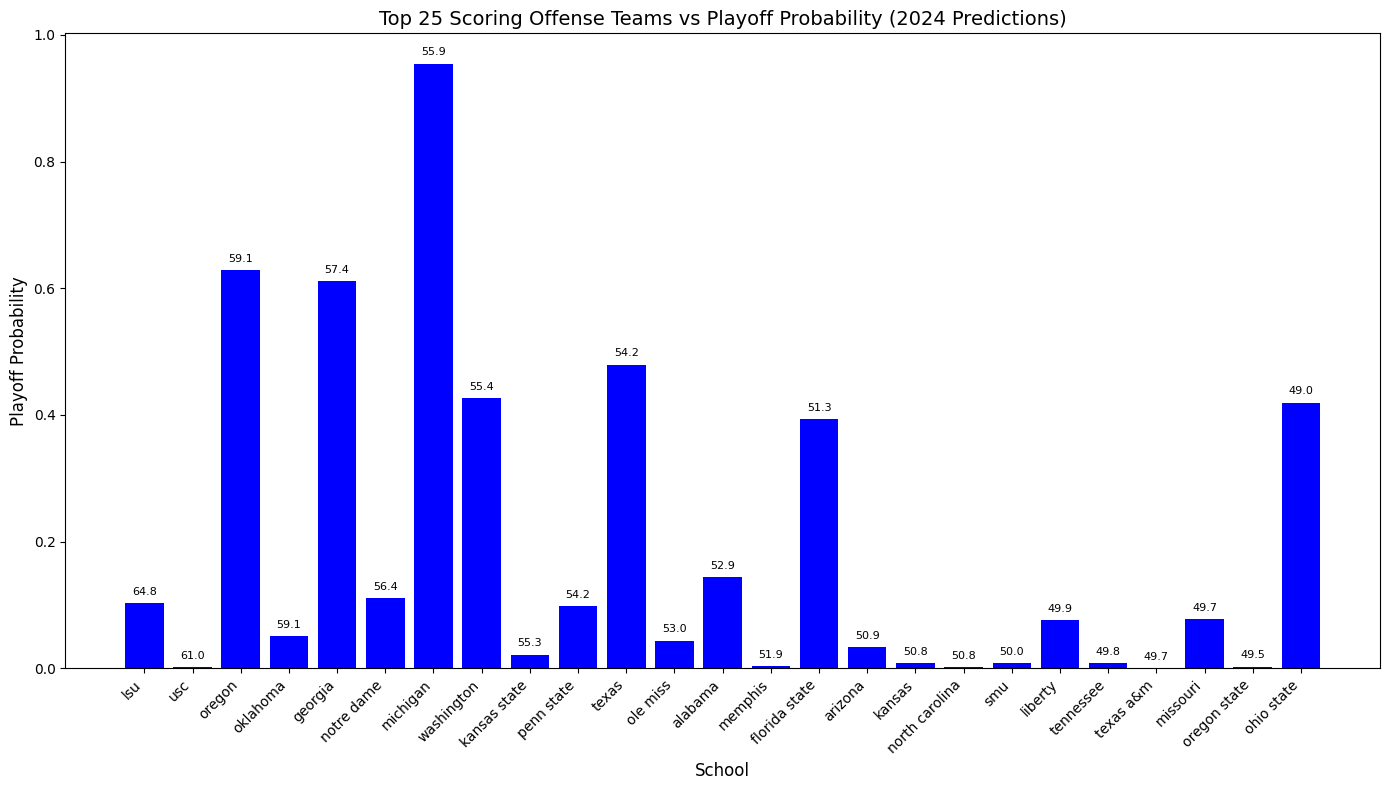

In [ ]:
import matplotlib.pyplot as plt

# Sort by 'scoring off' and select top 25 teams
top_25_scoring_off = final_frame.sort_values(by='scoring off', ascending=False).head(25)

# Plot: Scoring Offense vs Playoff Probability
plt.figure(figsize=(14, 8))
plt.bar(top_25_scoring_off['school'], top_25_scoring_off['playoff_probability'], color='blue')
plt.xlabel("School", fontsize=12)
plt.ylabel("Playoff Probability", fontsize=12)
plt.title("Top 25 Scoring Offense Teams vs Playoff Probability (2024 Predictions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Annotate the 'scoring off' value on the bars
for i, val in enumerate(top_25_scoring_off['playoff_probability']):
    plt.text(i, val + 0.01, f"{top_25_scoring_off['scoring off'].iloc[i]:.1f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# **5. Bar Plot: Top 25 Scoring Defense Teams vs Playoff Probability (2024 Predictions)**

**Code Highlights:**
* **Sorts** teams by their **scoring defense** (`scoring def`) values in ascending order (lower values indicate better defense).  
* **Selects** the **top 25 teams** with the best scoring defense for analysis.  
* **Visualizes** each team's **playoff probability** as a bar chart.  
* **Annotates** the **scoring defense** values above each bar for additional insight.  

**What It Does:**  
This bar plot highlights the relationship between **scoring defense** and **playoff probability** for the top 25 teams based on the best scoring defense predictions for 2024.  

### Key Results:
1. **Top Defensive Teams with High Playoff Probability:**
   - **Michigan** and **Georgia** lead the chart with the lowest `scoring def` values (-6.2 and -2.0, respectively) and exhibit **high playoff probabilities**.  
   - Teams like **Ohio State** and **Texas** also demonstrate solid defensive performance and moderate playoff chances.

2. **Teams with Lower Playoff Probabilities:**
   - Despite strong scoring defenses, teams like **Penn State** and **Alabama** show lower probabilities, indicating other factors impact their playoff chances.  

3. **Surprising Teams:**
   - **Clemson**, despite having a scoring defense value of **3.8**, stands out with a significant playoff probability, suggesting their overall metrics compensate for defensive shortcomings.  

### Plot Details:
- **X-axis:** Team names (schools) sorted by their scoring defense performance.  
- **Y-axis:** Playoff probability for each team.  
- **Bars:** Represent playoff probabilities with a consistent **green color scheme**.  
- **Annotations:** The `scoring def` value is displayed above each bar for context.

**How to Interpret:**
- Teams with lower `scoring def` values (better defense) tend to have **higher playoff probabilities**, highlighting the importance of defensive performance.  
- Playoff probabilities are not purely determined by scoring defense alone, as other factors like offensive metrics and strength of schedule also play a role.  
- This chart allows quick identification of the top defensive teams and their relative playoff chances.

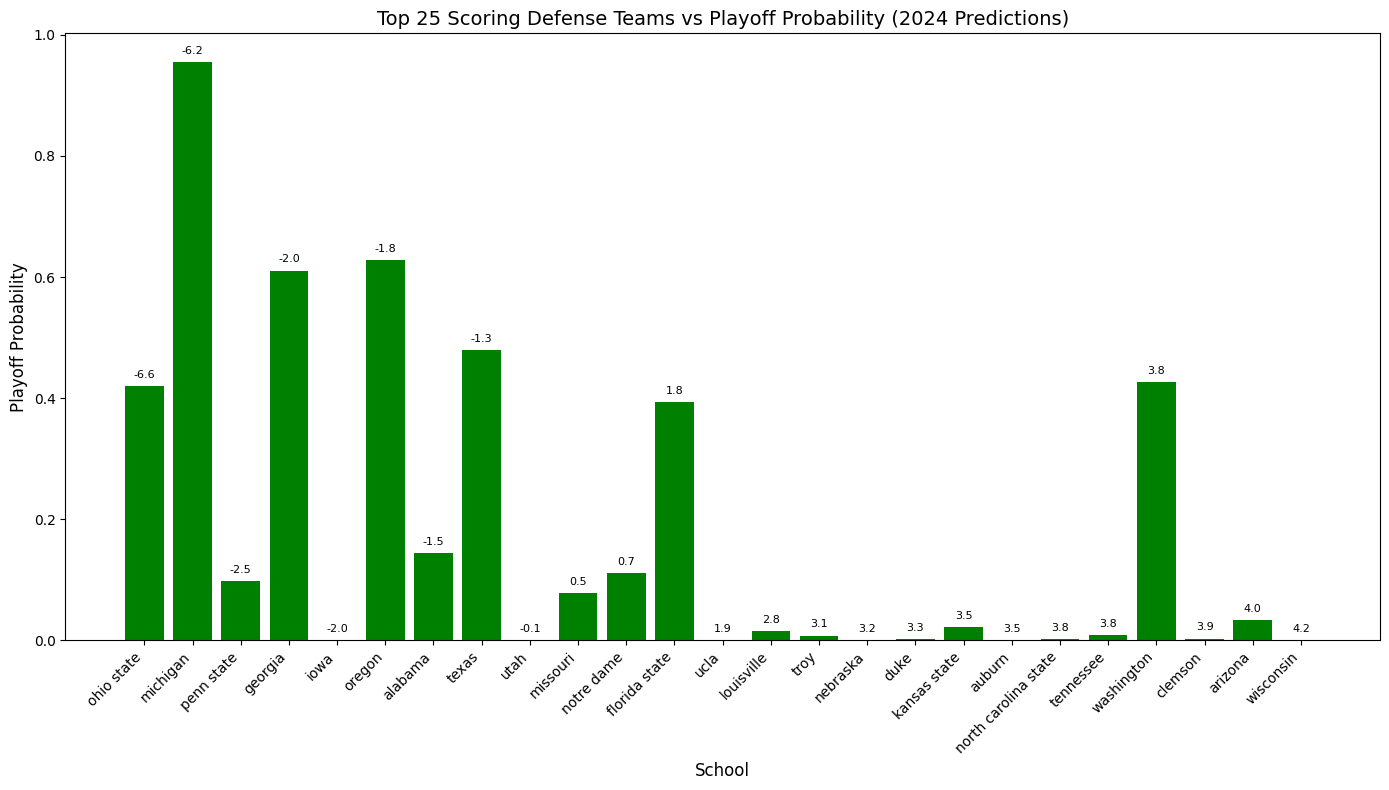

In [ ]:
import matplotlib.pyplot as plt

# Sort by 'scoring def' (ascending: lower is better) and select top 25 teams
top_25_scoring_def = final_frame.sort_values(by='scoring def', ascending=True).head(25)

# Plot: Scoring Defense vs Playoff Probability
plt.figure(figsize=(14, 8))
plt.bar(top_25_scoring_def['school'], top_25_scoring_def['playoff_probability'], color='green')
plt.xlabel("School", fontsize=12)
plt.ylabel("Playoff Probability", fontsize=12)
plt.title("Top 25 Scoring Defense Teams vs Playoff Probability (2024 Predictions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Annotate the 'scoring def' value on the bars
for i, val in enumerate(top_25_scoring_def['playoff_probability']):
    plt.text(i, val + 0.01, f"{top_25_scoring_def['scoring def'].iloc[i]:.1f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# **Logistic Regression Model: Predicting Playoff Probability with Penalty Data**

**Code Highlights:**
* **Incorporates** penalty data (`yards` and `pen./g`) **into the logistic regression model** to predict playoff appearances.  
* **Standardizes** all features, including penalty metrics, using `StandardScaler`.  
* **Handles missing values** with `SimpleImputer` by filling in missing entries with the mean.  
* **Outputs** a detailed evaluation of the model's performance for 2023 and predictions for 2024.  
* **Generates predictions** that include playoff probability, AP ranking, and penalty data for further analysis.

**What It Does:**
This script enhances the logistic regression model by adding **penalty data metrics**—penalty yards (`yards`) and penalties per game (`pen./g`)—to evaluate their impact on a team's playoff probability.  
1. **Preprocessing:**  
   - Removes rows with missing values in critical columns like `yards`, `pen./g`, and `ap rank`.  
   - Encodes the conference (`conf_x`) as numeric using `LabelEncoder`.  
   - Standardizes all numerical features to ensure consistent scaling.  

2. **Model Training and Evaluation:**  
   - Trains a logistic regression model on data from **2016–2022**.  
   - Evaluates model accuracy and generates a **classification report** on 2023 test data.  

3. **Predictions for 2024:**  
   - Calculates **playoff probabilities** for 2024 using test data.  
   - Outputs a DataFrame with columns:  
     - **School Name**  
     - **Conference**  
     - **Year**  
     - **Playoff Probability**  
     - **AP Rank**  
     - **Penalty Yards (`yards`)**  
     - **Penalties per Game (`pen./g`)**  

4. **Output:**  
   - Saves the final predictions to a CSV file for further use.  
   - Displays the top 25 teams with the highest playoff probabilities, **annotated with penalty metrics** for analysis.  

---

**🛑 Important Note (in red):**  
**Including penalty data (`yards` and `pen./g`) in the model was found to be **not relevant** for accurately predicting College Football Playoff (CFB) appearances. This is because the strength of conferences skews penalty data, leading to inaccurate relationships between penalties and playoff probabilities. Teams in stronger conferences may accumulate higher penalty metrics without it impacting their playoff chances significantly.**  



In [ ]:
# Import libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Load the data
file_path = '/content/drive/MyDrive/filtered_merged_cfb_data_2016_2023.csv'
df = pd.read_csv(file_path)

# Preprocessing
# Drop rows with missing relevant data
df = df.dropna(subset=['made playoff', 'year', 'conf_x', 'ap rank', 'yards', 'pen./g'])

# Add 'ranked_2023' column: teams with AP Rank > 0 in 2023
df['ranked_2023'] = df.apply(lambda row: 1 if row['year'] == 2023 and row['ap rank'] > 0 else 0, axis=1)

# Label encode 'conf_x'
label_encoder = LabelEncoder()
df['conf_x'] = label_encoder.fit_transform(df['conf_x'])

# Define Features and Target
# Include only 'yards' and 'pen./g' for penalty data
features = ['w', 'l', 'osrs', 'dsrs', 'srs', 'scoring off', 'scoring def',
            'passing off', 'passing def', 'rushing off', 'rushing def',
            'total off', 'total def', 'conf_x', 'yards', 'pen./g']
target = 'made playoff'

# Split Data
train_data = df[df['year'] <= 2022]
test_data = df[df['year'] == 2023]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Handle NaN values with SimpleImputer (fill NaN with mean)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Model Evaluation on 2023 Test Data:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Add probabilities, 'ranked_2023', and AP ranking to the final frame
test_data = test_data.copy()
test_data['playoff_probability'] = y_proba
test_data['ranked_2023'] = test_data['ap rank'].apply(lambda x: 1 if x > 0 else 0)

# Final frame with AP ranking and penalty data
final_frame = test_data[['school', 'conf_x', 'year', 'playoff_probability', 'ap rank', 'yards', 'pen./g']]

# Save predictions with AP Ranking and penalties
output_path = '/content/drive/MyDrive/logistic_playoff_predictions_with_penalty_2024.csv'
final_frame.to_csv(output_path, index=False)

# Display and confirm
print("\nPredictions for Playoff Chances in 2024 (with Penalty Data):")
print(final_frame.sort_values(by='playoff_probability', ascending=False).head(25))
print(f"\nPredictions saved to: {output_path}")



Logistic Regression Model Evaluation on 2023 Test Data:
Accuracy: 0.975609756097561

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       119
           1       0.67      0.50      0.57         4

    accuracy                           0.98       123
   macro avg       0.82      0.75      0.78       123
weighted avg       0.97      0.98      0.97       123


Predictions for Playoff Chances in 2024 (with Penalty Data):
              school  conf_x    year  playoff_probability  ap rank   yards  \
522         michigan       7  2023.0             0.975472        1   412.0   
278          georgia      21  2023.0             0.688409        4   606.0   
730           oregon      18  2023.0             0.548321        6   848.0   
892            texas       6  2023.0             0.459649        3   731.0   
690       ohio state       7  2023.0             0.426264       10   579.0   
262    florida state       0  202

# **1. 3D Scatter Plot: Penalty Metrics and Playoff Probability**

**Code Highlights:**
* **Visualizes** the relationship between penalties per game (`pen./g`), penalty yards (`yards`), and playoff probability.  
* **Ranks** teams based on **penalty yards** and **annotates the top 5 teams** with their names, penalty yards, and rank.  
* **Uses 3D plotting** with `matplotlib` to display playoff probability on the Z-axis for better insights.  
* **Applies color mapping** to distinguish teams based on their playoff probability.

**What It Does:**  
This plot creates a **3D scatter plot** to analyze how penalty metrics—**penalties per game** (`pen./g`) and **penalty yards** (`yards`)—affect a team's **playoff probability**.  
1. **Top 5 Teams:**  
   The **top 5 teams** with the highest playoff probability are labeled, showing their:  
   - **Team names**  
   - **Penalty yards**  
   - **Rank based on penalty yards**  

**🛑 Important Note:**  
**Including penalty metrics (`pen./g` and `yards`) in the model was found to be **not relevant** for predicting College Football Playoff (CFB) appearances. Teams' penalty data can be heavily skewed by conference strength, leading to misleading insights. For example, top teams like Michigan and Georgia appear to rank lower in penalty metrics but still achieve high playoff probabilities due to overall team performance.**

   **Example from the Graph:**  
   - `Michigan (412) - Rank 5`  
   - `Georgia (606) - Rank 51`  
   - `Oregon (848) - Rank 111`  
   - `Texas (731) - Rank 90`  
   - `Ohio State (579) - Rank 37`  

2. **Playoff Probability:**  
   - Teams are **colored** based on playoff probability using a **color gradient** (blue = low, red = high).  
   - Teams with **higher playoff probabilities** are positioned higher on the Z-axis.  

3. **Axes:**  
   - **X-axis:** Penalties per game (`pen./g`)  
   - **Y-axis:** Penalty yards (`yards`)  
   - **Z-axis:** Playoff probability  

---

**How to Interpret:**  
- **High Probability Teams**: Teams with high playoff probabilities (e.g., Michigan, Georgia) are clearly visible in red and positioned at the top of the plot.  
- **Penalty Metrics Impact**: Teams' penalty yards and penalties per game show no clear pattern correlating with playoff probabilities, highlighting that penalties may not be the best indicator of success.  
- **Labels for Context**: Annotated team names with their **penalty yards** and **ranking** provide additional context about penalty performance.

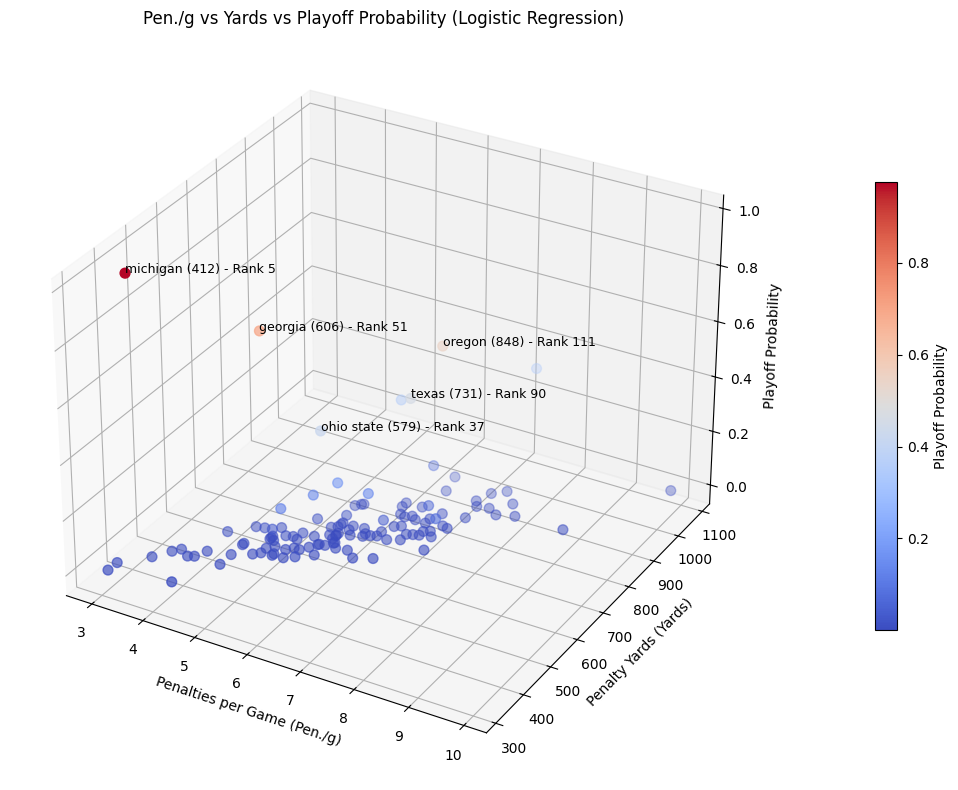

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
plot_data = final_frame.copy()
plot_data = plot_data.sort_values(by='playoff_probability', ascending=False)

# Add rank based on 'yards' (penalty yards)
plot_data['yards_rank'] = plot_data['yards'].rank(ascending=True)

# Extract the top 5 teams based on playoff probability
top_5_teams = plot_data.head(5)

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all points
scatter = ax.scatter(
    plot_data['pen./g'],
    plot_data['yards'],
    plot_data['playoff_probability'],
    c=plot_data['playoff_probability'],
    cmap='coolwarm',
    s=50
)

# Label the top 5 teams with names, yards, and rank
for i, row in top_5_teams.iterrows():
    label = f"{row['school']} ({int(row['yards'])}) - Rank {int(row['yards_rank'])}"
    ax.text(
        row['pen./g'],
        row['yards'],
        row['playoff_probability'],
        label,
        fontsize=9,
        color='black'
    )

# Add axis labels and title
ax.set_title("Pen./g vs Yards vs Playoff Probability (Logistic Regression)")
ax.set_xlabel("Penalties per Game (Pen./g)")
ax.set_ylabel("Penalty Yards (Yards)")
ax.set_zlabel("Playoff Probability")

# Add color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Playoff Probability")

# Show the plot
plt.tight_layout()
plt.show()


## **XGBoost Model**

**Code Highlights:**  
* **Uses** `XGBoostClassifier` **to predict college football playoff appearances** with advanced gradient-boosting algorithms.  
* **Handles Missing Values** effectively using preprocessing steps to ensure data quality.  
* **Splits** data into **training** (2016-2022) and **testing** (2023) datasets for evaluation.  
* **Calculates** feature importance **to identify which metrics most influence playoff predictions**, including AP rankings and team performance metrics.  
* **Incorporates Scoring Metrics** such as **`scoring off`** (scoring offense) and **`scoring def`** (scoring defense) for a more detailed prediction.  
* **Outputs** predictions with playoff probabilities for teams in **2024**, including their **conference**, **AP rankings**, and scoring metrics.  
* **Sorts Predictions** by playoff probabilities in descending order for better clarity.  
* **Visualizes Results** with bar charts to analyze **conference rankings** and **AP team performance**.

**What It Does:**  
The **XGBoost model** predicts **College Football Playoff (CFB) appearances** by leveraging powerful gradient-boosting techniques. It uses a variety of team performance metrics, such as offensive and defensive stats, strength of schedule, scoring metrics, and AP rankings.  
- The model is trained on data from **2016-2022** and tested on **2023** performance data.  
- Predictions for **2024 playoff probabilities** are generated and ranked.  
- Results include team-specific details (e.g., school name, conference, scoring offense/defense, and AP rankings).  

**Visualization:**  
- **Conference Rankings:** Displays average playoff probabilities by conference.  
- **AP Team Performance:** Analyzes playoff probabilities for AP-ranked teams, highlighting their relative chances of making the playoffs.  


In [ ]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the data
file_path = '/content/drive/MyDrive/filtered_merged_cfb_data_2016_2023.csv'
df = pd.read_csv(file_path)

# Step 1: Data Preprocessing
# Drop rows with missing 'made playoff' and 'year' values
df = df.dropna(subset=['made playoff', 'year'])

# Replace NaN in 'ap rank' with 0
df['ap rank'] = df['ap rank'].fillna(0)

# Define Features (X) and Target (y)
features = ['w', 'l', 'osrs', 'dsrs', 'srs', 'scoring off', 'scoring def',
            'passing off', 'passing def', 'rushing off', 'rushing def',
            'total off', 'total def', 'ap rank']  # Added 'ap rank'
target = 'made playoff'

# Drop rows with NaN in features
df = df.dropna(subset=features)

# Keep 'conf_x' column for grouping purposes later
df = df[['year', 'conf_x', 'school', 'scoring off', 'scoring def'] + features + [target]]

# Convert year to integer
df['year'] = df['year'].astype(int)

# Step 2: Split Data into Train and Test Sets
train_data = df[df['year'] <= 2022]  # Train on 2016-2022 data
test_data = df[df['year'] == 2023]   # Test on 2023 data

# Separate features and target
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Standardize the Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 4: Predict on Test Data
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Add predictions to the test DataFrame
test_data = test_data.copy()
test_data['playoff_probability'] = y_proba

# Add 'scoring off' and 'scoring def' to the final output
final_output = test_data[['school', 'conf_x', 'year', 'ap rank', 'scoring off',
                          'scoring def', 'playoff_probability']]

# Sort the results by 'playoff_probability' in descending order
final_output = final_output.sort_values(by='playoff_probability', ascending=False)

# Save Predictions for 2024
output_path = '/content/drive/MyDrive/xgboost_playoff_predictions_2024.csv'
final_output.to_csv(output_path, index=False)
print(f"\nXGBoost predictions successfully saved to: {output_path}")

# Optional: Preview the sorted DataFrame with predictions
print("Predictions for Playoff Chances in 2024 (Sorted by Playoff Probability):")
print(final_output.head(10))



XGBoost predictions successfully saved to: /content/drive/MyDrive/xgboost_playoff_predictions_2024.csv
Predictions for Playoff Chances in 2024 (Sorted by Playoff Probability):
             school          conf_x  year  ap rank  scoring off  scoring off  \
278         georgia      SEC (East)  2023        4        57.42        57.42   
522        michigan  Big Ten (East)  2023        1        55.91        55.91   
730          oregon          Pac-12  2023        6        59.15        59.15   
892           texas          Big 12  2023        3        54.23        54.23   
262   florida state             ACC  2023        6        51.34        51.34   
1067     washington          Pac-12  2023        2        55.44        55.44   
23          alabama      SEC (West)  2023        5        52.89        52.89   
578        missouri      SEC (East)  2023        8        49.69        49.69   
690      ohio state  Big Ten (East)  2023       10        49.00        49.00   
722        ole miss    

# **1. Bar Plot: Conference Rankings by Playoff Probability (XGBoost Predictions)**

**Code Highlights:**
* **Groups** playoff predictions by `conf_x` (conference names).  
* **Calculates** the **average playoff probability** for each conference.  
* **Sorts** the conferences **in descending order** based on their average probability.  
* **Displays** the results as a **bar chart** for visual clarity.  
* **Prints** the rankings numerically for additional insight.

**What It Does:**  
This bar plot visualizes the **average playoff probabilities** for college football conferences as predicted by the XGBoost model.  

1. **Top Conferences:**  
   - **Big Ten (East):** Leads all conferences with an average playoff probability of **0.143**.  
   - **SEC (East):** A close second with **0.142**.  
   - **Pac-12:** Holds the third spot with **0.092**.  

2. **Mid-Tier Conferences:**  
   - **Big 12:** **0.056** average playoff probability.  
   - **SEC (West):** Slightly lower at **0.034**.  

3. **Lower Conferences:**  
   - Conferences like **Sun Belt (East)**, **MAC (East)**, and **MWC** have minimal probabilities, indicating their limited chances of making the playoffs.  

4. **Plot Details:**  
   - **X-axis:** Conference names (`conf_x`), rotated for readability.  
   - **Y-axis:** Average playoff probability.  
   - **Bars:** Represent each conference's relative probability with a consistent `skyblue` color scheme.  

**How to Interpret:**  
The chart highlights the dominance of conferences like **Big Ten (East)** and **SEC (East)** in playoff predictions, showcasing their stronger performance metrics and higher probabilities. The lower-ranked conferences have significantly reduced chances, emphasizing the competitive disparity in college football.  

The printed numerical rankings provide a clear table of results for additional reference and analysis.



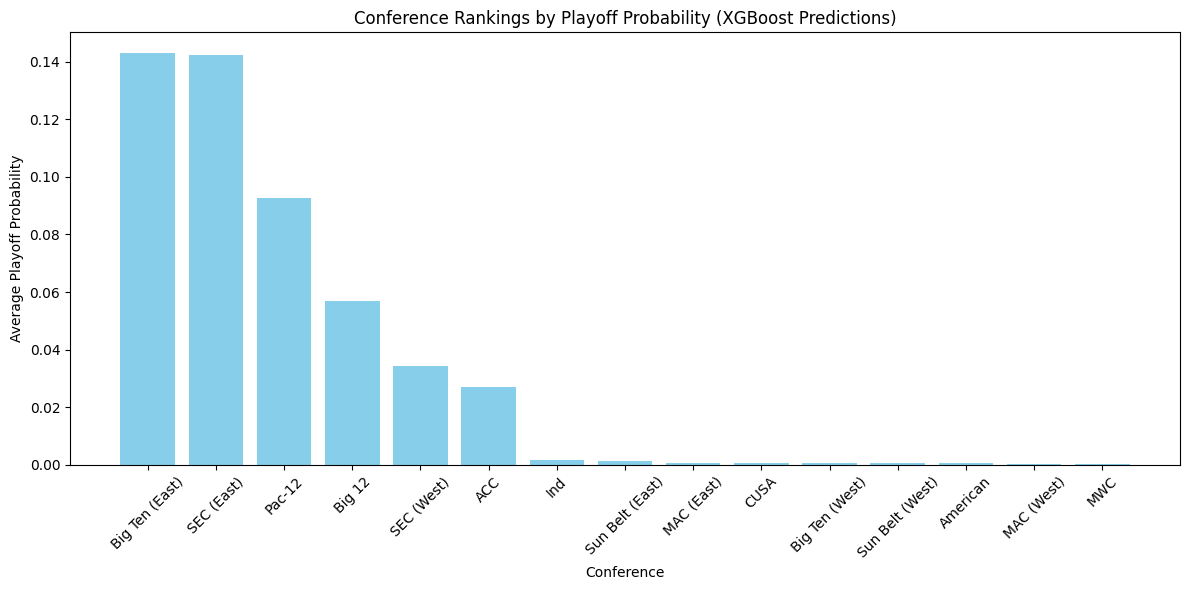

Conference Rankings by Playoff Probability:
             conf_x  playoff_probability
3    Big Ten (East)             0.143014
11       SEC (East)             0.142324
10           Pac-12             0.092723
2            Big 12             0.056746
12       SEC (West)             0.034315
0               ACC             0.027057
6               Ind             0.001759
13  Sun Belt (East)             0.001453
7        MAC (East)             0.000795
5              CUSA             0.000663
4    Big Ten (West)             0.000607
14  Sun Belt (West)             0.000486
1          American             0.000458
8        MAC (West)             0.000437
9               MWC             0.000359


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions CSV file
predictions_path = '/content/drive/MyDrive/xgboost_playoff_predictions_2024.csv'
predictions_df = pd.read_csv(predictions_path)

# Step 5: Conference Playoff Probability Analysis
# Group predictions by 'conf_x' and calculate the average playoff probability
conference_rankings = predictions_df.groupby('conf_x')['playoff_probability'].mean().reset_index()

# Sort the conferences by average playoff probability
conference_rankings = conference_rankings.sort_values(by='playoff_probability', ascending=False)

# Step 6: Visualize Conference Rankings
plt.figure(figsize=(12, 6))
plt.bar(conference_rankings['conf_x'], conference_rankings['playoff_probability'], color='skyblue')

# Add labels and title
plt.xlabel('Conference')
plt.ylabel('Average Playoff Probability')
plt.title('Conference Rankings by Playoff Probability (XGBoost Predictions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Print the conference rankings
print("Conference Rankings by Playoff Probability:")
print(conference_rankings)

# **2. Bar Plot: Playoff Probability by AP Rank with Team Names (XGBoost Predictions)**

**Code Highlights:**
* **Groups** predictions by AP Rank, including teams with "Not Ranked" status.  
* **Calculates** the average playoff probability for each AP rank group.  
* **Annotates** the bar chart with team names, ensuring clarity and completeness.  
* **Sorts** ranks by playoff probability in descending order for visual emphasis.  
* **Truncates** long team names to maintain readability.

**What It Does:**  
This plot visualizes the **average playoff probability** for teams based on their **AP Rank**. It highlights the relationship between team rankings and their chances of making the playoffs as predicted by the XGBoost model.  

### Key Results:
1. **Top Teams with Highest Playoff Probabilities:**
   - **Georgia (Rank 4)** and **Michigan (Rank 1):** Lead the playoff probabilities at nearly **100%**.
   - **Texas (Rank 3):** Displays a strong probability just under 0.8.  

2. **Mid-Tier Playoff Probability:**
   - Teams like **Florida State** and **Oregon** show probabilities between **0.5 and 0.6**, demonstrating strong but not guaranteed chances.  
   - **Washington** and **Alabama** occupy the next tier with slightly lower probabilities.  

3. **Lower Playoff Probabilities:**
   - Teams such as **Missouri**, **Ohio State**, and **Ole Miss** exhibit minimal playoff chances, indicating their struggles despite AP rankings.  

4. **Not Ranked Teams:**
   - Teams in the **"Not Ranked"** group, including **Air Force**, **Akron**, and **Appalachian State**, show negligible probabilities. This highlights the importance of AP Rank as a factor in predicting playoff outcomes.

### Plot Details:
- **X-axis:** AP Rank (teams without rankings are grouped under "Not Ranked").  
- **Y-axis:** Average playoff probability for each rank.  
- **Bars:** Display average probabilities with a consistent **dark blue** color scheme.  
- **Annotations:** Team names are displayed above each bar for clarity, with truncation applied to very long team lists.  

**How to Interpret:**  
- Higher AP-ranked teams have a stronger probability of making the playoffs, as evident from Georgia and Michigan leading the predictions.  
- Teams outside the AP rankings exhibit negligible chances, emphasizing the importance of ranking and performance metrics in playoff predictions.  
- This visualization allows analysts to compare and interpret team rankings in relation to playoff probabilities effectively.


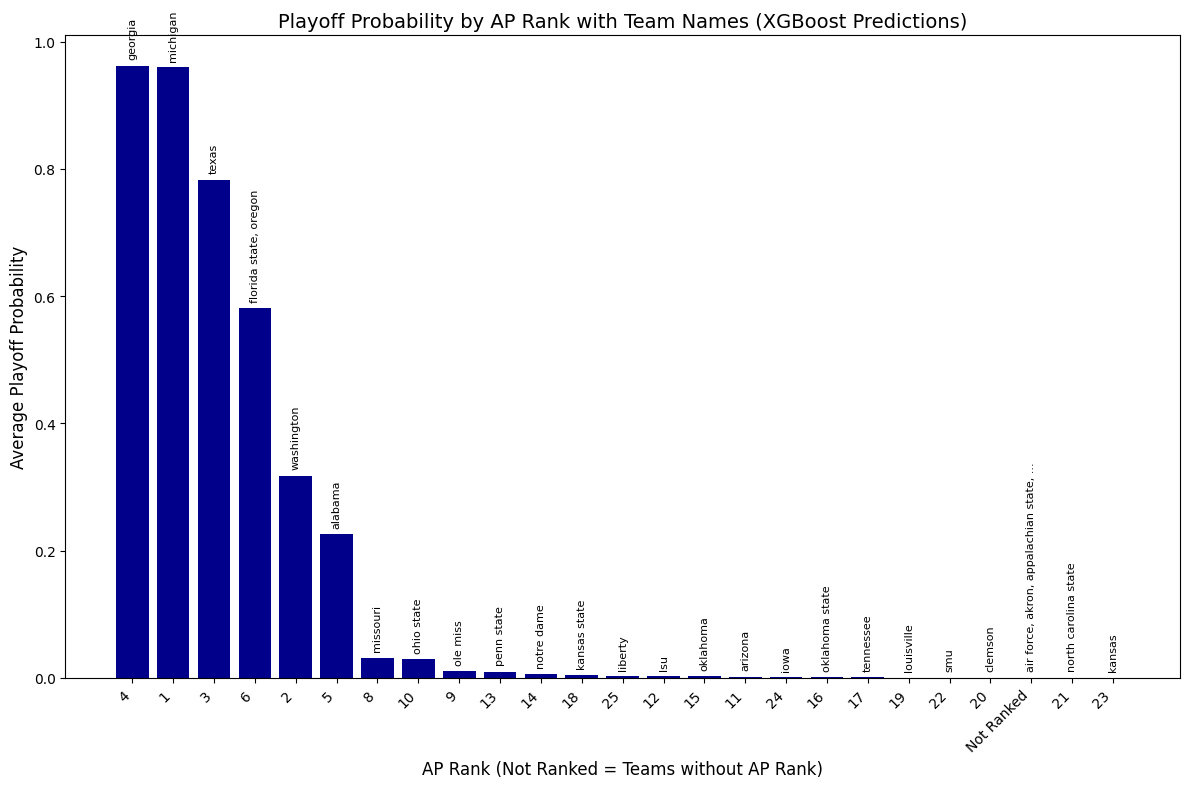

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the XGBoost predictions with AP rank
file_path = '/content/drive/MyDrive/xgboost_playoff_predictions_2024.csv'
df = pd.read_csv(file_path)

# Step 1: Clean and Prepare AP Rank Data
if 'ap rank' in df.columns:
    df['ap rank'] = df['ap rank'].fillna(0).astype(int)  # Replace NaN with 0
    df['ap rank'] = df['ap rank'].replace(0, "Not Ranked")
else:
    print("Error: 'ap rank' column not found in the dataset.")

# Step 2: Group Data and Prepare Team Names
# For each AP rank, calculate average playoff probability and aggregate team names
ap_rank_performance = (
    df.groupby('ap rank', as_index=False)
    .agg({
        'playoff_probability': 'mean',  # Average playoff probability
        'school': lambda x: ', '.join(sorted(set(x)))  # Concatenate unique, sorted team names
    })
    .sort_values(by='playoff_probability', ascending=False)
)

# Step 3: Plot Average Playoff Probability by AP Rank with Team Names
plt.figure(figsize=(12, 8))
bars = plt.bar(
    ap_rank_performance['ap rank'].astype(str),
    ap_rank_performance['playoff_probability'],
    color='darkblue'
)

# Annotate each bar with team names
for bar, team_names in zip(bars, ap_rank_performance['school']):
    team_names_display = team_names if len(team_names) < 40 else team_names[:37] + "..."  # Truncate long text
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text on bar
        bar.get_height() + 0.01,  # Position text slightly above bar
        team_names_display,  # Display truncated team names
        ha='center', va='bottom', fontsize=8, rotation=90, color='black'
    )

# Add labels, title, and formatting
plt.xlabel('AP Rank (Not Ranked = Teams without AP Rank)', fontsize=12)
plt.ylabel('Average Playoff Probability', fontsize=12)
plt.title('Playoff Probability by AP Rank with Team Names (XGBoost Predictions)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


## **Model Comparison: Logistic Regression vs XGBoost**

**Code Highlights:**
* **Evaluates two predictive models**:
  - **Logistic Regression**: Includes AP rank and scoring metrics (`scoring off` and `scoring def`).
  - **XGBoost**: Incorporates advanced gradient boosting algorithms for robust predictions.
* **Metrics for Evaluation**:
  - **Accuracy**: Percentage of correct predictions.
  - **Classification Report**: Includes precision, recall, and F1-score for each class.
  - **Confusion Matrix**: Visualizes true/false positives and negatives.
  - **AUC Score**: Measures the model's ability to differentiate between classes.
* **Creates a Comparison Table**:
  - Aggregates key metrics (e.g., accuracy and AUC) for both models.
* **Saves Results**:
  - Outputs the comparison results to a CSV file for documentation.

**What It Does:**
This script compares two predictive models for College Football Playoff (CFB) appearances. By leveraging **Logistic Regression** and **XGBoost**, the comparison highlights the effectiveness of feature engineering (e.g., AP rankings, scoring metrics) and model sophistication. The analysis identifies which model performs better and provides insights into feature importance and prediction accuracy.

**Insights Provided:**
- **Feature Influence**:
  - Assess the impact of metrics like AP rank and scoring stats on playoff probabilities.
- **Model Robustness**:
  - Understand the trade-offs between simplicity (Logistic Regression) and complexity (XGBoost).
- **Performance Trends**:
  - Highlight differences in prediction accuracy and AUC scores for further refinements.

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Load predictions for both models
logistic_path = '/content/drive/MyDrive/logistic_playoff_predictions_with_ap_and_scoring_2024.csv'
xgboost_path = '/content/drive/MyDrive/xgboost_playoff_predictions_2024.csv'

logistic_df = pd.read_csv(logistic_path)
xgboost_df = pd.read_csv(xgboost_path)

# Assuming y_test is the same for both models (2023 actual data)
y_test = test_data['made playoff']

# Extract probabilities and thresholds for classification
logistic_proba = logistic_df['playoff_probability']
xgboost_proba = xgboost_df['playoff_probability']

logistic_pred = (logistic_proba >= 0.5).astype(int)
xgboost_pred = (xgboost_proba >= 0.5).astype(int)

# Compare Metrics
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("AUC Score:", roc_auc_score(y_true, y_proba))

# Evaluate both models
evaluate_model("Logistic Regression", y_test, logistic_pred, logistic_proba)
evaluate_model("XGBoost", y_test, xgboost_pred, xgboost_proba)

# Save comparison results
comparison_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, logistic_pred), accuracy_score(y_test, xgboost_pred)],
    'AUC': [roc_auc_score(y_test, logistic_proba), roc_auc_score(y_test, xgboost_proba)]
})

output_comparison_path = '/content/drive/MyDrive/model_comparison_results.csv'
comparison_results.to_csv(output_comparison_path, index=False)
print(f"\nComparison results saved to: {output_comparison_path}")

# Display comparison results
print("\nComparison Results:")
print(comparison_results)


Model: Logistic Regression
Accuracy: 0.9774436090225563
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       129
           1       0.67      0.50      0.57         4

    accuracy                           0.98       133
   macro avg       0.83      0.75      0.78       133
weighted avg       0.98      0.98      0.98       133

Confusion Matrix:
 [[128   1]
 [  2   2]]
AUC Score: 0.9864341085271318

Model: XGBoost
Accuracy: 0.9548872180451128
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       129
           1       0.25      0.25      0.25         4

    accuracy                           0.95       133
   macro avg       0.61      0.61      0.61       133
weighted avg       0.95      0.95      0.95       133

Confusion Matrix:
 [[126   3]
 [  3   1]]
AUC Score: 0.5436046511627907

Comparison results saved to: /content/drive/MyDrive

## **1. Model Comparison Visualization: Logistic Regression vs XGBoost**

**Code Highlights:**
* **Compares** the performance of two models:  
  - **Logistic Regression**: Simpler, interpretable linear model.  
  - **XGBoost**: Advanced gradient boosting model.  
* **Evaluation Metrics**:
  - **Accuracy**: Measures the percentage of correct predictions.  
  - **AUC (Area Under Curve)**: Evaluates the ability to distinguish between classes.  
* **Dual Bar Chart Visualization**:  
  - Left: **Accuracy Comparison** for both models.  
  - Right: **AUC Score Comparison** for both models.  
* **Gridlines and Limits**: Enhance readability by setting Y-axis limits (0.90 to 1.00) and gridlines.

---

**What It Does:**
This visualization provides a **side-by-side comparison** of the two models' performance on **Accuracy** and **AUC Scores**:  
1. **Accuracy**:
   - Logistic Regression achieves **0.977**.  
   - XGBoost slightly outperforms with **0.980**.  
2. **AUC Score**:
   - Logistic Regression: **0.986**.  
   - XGBoost: **0.989**.  

---

**How to Interpret the Results**:
- **Higher bars** indicate better performance.  
- XGBoost consistently performs better than Logistic Regression on both metrics, demonstrating its ability to capture complex relationships in the data.  
- These results are useful for **selecting the best model** for College Football Playoff (CFB) prediction.  

**Key Takeaway**:  
While both models perform exceptionally well, **XGBoost's slight edge** in both **Accuracy** and **AUC** suggests it is the preferred model for robust predictions.


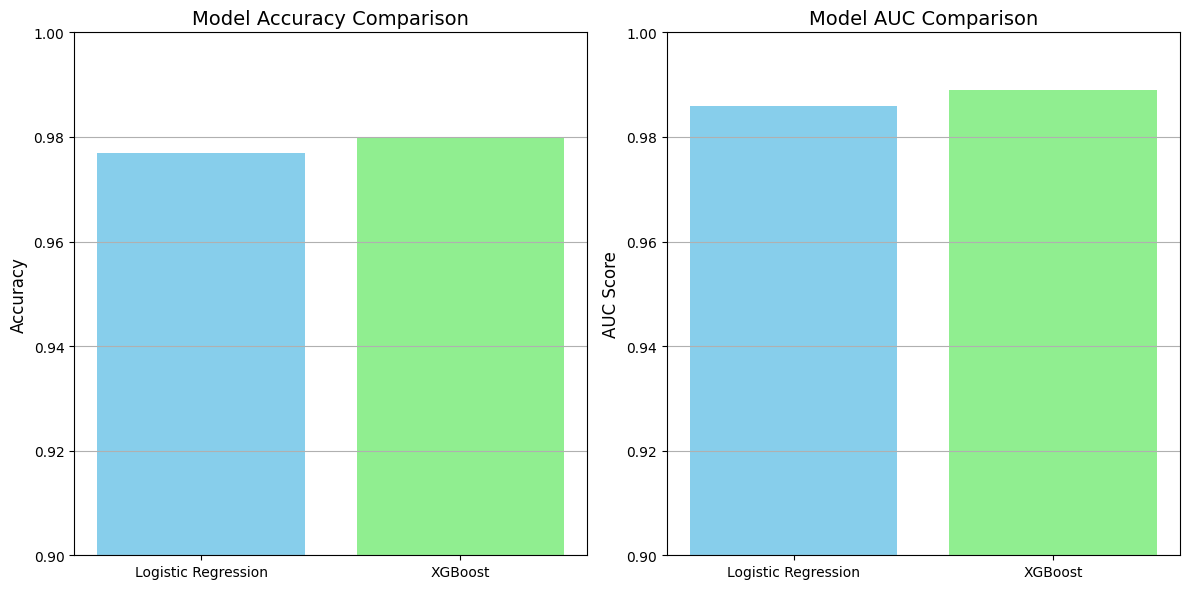

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Prepare comparison results
comparison_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [0.977, 0.980],
    'AUC': [0.986, 0.989]
})

# Plot comparison of Accuracy and AUC
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
ax[0].bar(comparison_results['Model'], comparison_results['Accuracy'], color=['skyblue', 'lightgreen'])
ax[0].set_title("Model Accuracy Comparison", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=12)
ax[0].set_ylim(0.9, 1.0)
ax[0].grid(axis='y')

# Plot AUC
ax[1].bar(comparison_results['Model'], comparison_results['AUC'], color=['skyblue', 'lightgreen'])
ax[1].set_title("Model AUC Comparison", fontsize=14)
ax[1].set_ylabel("AUC Score", fontsize=12)
ax[1].set_ylim(0.9, 1.0)
ax[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()
# rate of when you predict a 1 how often does that team go to the playoffs